In [1]:
#coding=utf-8
%matplotlib inline
import mxnet as mx
import numpy as np 
import cv2, random
import matplotlib.pyplot as plt
import logging
import re
import glob
from PIL import Image

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
indexu= {u"京": 0, u"沪": 1, u"津": 2, u"渝": 3, u"冀": 4, u"晋": 5, u"蒙": 6, u"辽": 7, u"吉": 8, u"黑": 9, u"苏": 10, u"浙": 11, u"皖": 12,
         u"闽": 13, u"赣": 14, u"鲁": 15, u"豫": 16, u"鄂": 17, u"湘": 18, u"粤": 19, u"桂": 20, u"琼": 21, u"川": 22, u"贵": 23, u"云": 24,
         u"藏": 25, u"陕": 26, u"甘": 27, u"青": 28, u"宁": 29, u"新": 30,"0": 31, "1": 32, "2": 33, "3": 34, "4": 35, "5": 36,
         "6": 37, "7": 38, "8": 39, "9": 40, "A": 41, "B": 42, "C": 43, "D": 44, "E": 45, "F": 46, "G": 47, "H": 48,
         "J": 49, "K": 50, "L": 51, "M": 52, "N": 53, "P": 54, "Q": 55, "R": 56, "S": 57, "T": 58, "U": 59, "V": 60,
         "W": 61, "X": 62, "Y": 63, "Z": 64};

def r(val):
    return int(np.random.random() * val)

def rand_range(lo,hi):
    return lo+r(hi-lo);

def gen_rand_getImg(cnt):
    name = "";
    label= [];
    
    nPref=rand_range(0,cnt)
    strPref=str(nPref).zfill(4)
    strFilename=glob.glob('plate_train/'+strPref+'.*.jpg')
    ##The following line is going to produce nsarray of 72*272*3
    img = cv2.imread(strFilename[0],-1)
    ##The following line is going to produce nsarray of 72*272
    #img=cv2.imread(strFilename[0],cv2.IMREAD_GRAYSCALE)
    #img = Image.open(strFilename[0], 'r')
    #resize to 30*120*3
    img = cv2.resize(img, (120, 30))
    img = np.multiply(img, 1/255.0)
    #change to 3*30*120
    img = img.transpose(2, 0, 1)
    
    name=''
    m = re.search('\.(.+?)\.jpg', strFilename[0])
    if m:
        name = m.group(1)
    
    for c in name.decode('utf-8'):
        label.append(indexu[c])

    return name,label,img

In [3]:
name,label,img=gen_rand_getImg(6000)

In [4]:
print name

桂XPDAKH


In [5]:
print label

[20, 62, 54, 44, 41, 50, 48]


TypeError: Invalid dimensions for image data

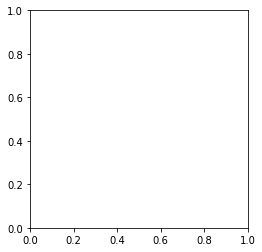

In [6]:
from matplotlib.pyplot import imshow
imshow(np.asarray(img))

In [6]:
array = mx.nd.array(img)
print array.shape

(3L, 30L, 120L)


In [7]:
class OCRBatch(object):
    def __init__(self, data_names, data, label_names, label):
        self.data = data
        self.label = label
        self.data_names = data_names
        self.label_names = label_names

    @property
    def provide_data(self):
        return [(n, x.shape) for n, x in zip(self.data_names, self.data)]

    @property
    def provide_label(self):
        return [(n, x.shape) for n, x in zip(self.label_names, self.label)]
    
class OCRIter(mx.io.DataIter):
    def __init__(self, count, batch_size, num_label, height, width):
        super(OCRIter, self).__init__()
        #self.genplate = GenPlate("./font/platech.ttf",'./font/platechar.ttf','./NoPlates')
        self.batch_size = batch_size
        self.count = count
        self.height = height
        self.width = width
        self.provide_data = [('data', (batch_size, 3, height, width))]
        self.provide_label = [('softmax_label', (self.batch_size, num_label))]
        print "start"
    def __iter__(self):

        for k in range(self.count / self.batch_size):
            data = []
            label = []
            for i in range(self.batch_size):
                name,lbl,img=gen_rand_getImg(self.count)
                #print lbl
                data.append(img)
                label.append(lbl)

            data_all = [mx.nd.array(data)]
            label_all = [mx.nd.array(label)]
            data_names = ['data']
            label_names = ['softmax_label']
            data_batch = OCRBatch(data_names, data_all, label_names, label_all)
            yield data_batch

    def reset(self):
        pass

In [8]:
def get_ocrnet():
    data = mx.symbol.Variable('data')
    label = mx.symbol.Variable('softmax_label')
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=32)
    pool1 = mx.symbol.Pooling(data=conv1, pool_type="max", kernel=(2,2), stride=(1, 1))
    relu1 = mx.symbol.Activation(data=pool1, act_type="relu")

    conv2 = mx.symbol.Convolution(data=relu1, kernel=(5,5), num_filter=32)
    pool2 = mx.symbol.Pooling(data=conv2, pool_type="avg", kernel=(2,2), stride=(1, 1))
    relu2 = mx.symbol.Activation(data=pool2, act_type="relu")

    # conv3 = mx.symbol.Convolution(data=relu2, kernel=(3,3), num_filter=32)
    # pool3 = mx.symbol.Pooling(data=conv3, pool_type="avg", kernel=(2,2), stride=(1, 1))
    # relu3 = mx.symbol.Activation(data=pool3, act_type="relu")
    #
    # conv4 = mx.symbol.Convolution(data=relu3, kernel=(3,3), num_filter=32)
    # pool4 = mx.symbol.Pooling(data=conv4, pool_type="avg", kernel=(2,2), stride=(1, 1))
    # relu4 = mx.symbol.Activation(data=pool4, act_type="relu")

    flatten = mx.symbol.Flatten(data = relu2)
    fc1 = mx.symbol.FullyConnected(data = flatten, num_hidden = 120)
    fc21 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc22 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc23 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc24 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc25 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc26 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc27 = mx.symbol.FullyConnected(data = fc1, num_hidden = 65)
    fc2 = mx.symbol.Concat(*[fc21, fc22, fc23, fc24,fc25,fc26,fc27], dim = 0)
    label = mx.symbol.transpose(data = label)
    label = mx.symbol.Reshape(data = label, target_shape = (0, ))
    return mx.symbol.SoftmaxOutput(data = fc2, label = label, name = "softmax")


def Accuracy(label, pred):
    label = label.T.reshape((-1, ))
    hit = 0
    total = 0
    for i in range(pred.shape[0] / 7):
        ok = True
        for j in range(7):
            k = i * 7 + j
            if np.argmax(pred[k]) != int(label[k]):
                ok = False
                break
        if ok:
            hit += 1
        total += 1
    return 1.0 * hit / total

In [9]:
network = get_ocrnet()
model = mx.model.FeedForward(
                             symbol = network,
                             num_epoch = 20,
                             learning_rate = 0.01,
                             wd = 0.001,
                             initializer = mx.init.Xavier(factor_type="in", magnitude=2.34),
                             momentum = 0.9)
batch_size = 50
data_train = OCRIter(6000, batch_size, 7, 30, 120)
data_test = OCRIter(200, batch_size,7, 30, 120)
print("start logging")
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)
model.fit(X = data_train, eval_data = data_test, eval_metric = Accuracy, batch_end_callback=mx.callback.Speedometer(batch_size, 50))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
  
/home/liuhaian/src/incubator-mxnet/python/mxnet/model.py:547: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
2017-09-14 14:28:25,663 Start training with [cpu(0)]


start
start
start logging


2017-09-14 14:29:56,108 Epoch[0] Batch [50]	Speed: 28.08 samples/sec	Accuracy=0.000000
2017-09-14 14:31:25,726 Epoch[0] Batch [100]	Speed: 27.90 samples/sec	Accuracy=0.000000
2017-09-14 14:32:01,662 Epoch[0] Resetting Data Iterator
2017-09-14 14:32:01,663 Epoch[0] Time cost=215.981
2017-09-14 14:32:05,949 Epoch[0] Validation-Accuracy=0.000000
2017-09-14 14:33:35,397 Epoch[1] Batch [50]	Speed: 28.27 samples/sec	Accuracy=0.000000
2017-09-14 14:35:05,502 Epoch[1] Batch [100]	Speed: 27.75 samples/sec	Accuracy=0.000000
2017-09-14 14:35:42,167 Epoch[1] Resetting Data Iterator
2017-09-14 14:35:42,169 Epoch[1] Time cost=216.219
2017-09-14 14:35:46,550 Epoch[1] Validation-Accuracy=0.000000
2017-09-14 14:37:15,499 Epoch[2] Batch [50]	Speed: 28.39 samples/sec	Accuracy=0.000000
2017-09-14 14:38:45,298 Epoch[2] Batch [100]	Speed: 27.84 samples/sec	Accuracy=0.000000
2017-09-14 14:39:21,553 Epoch[2] Resetting Data Iterator
2017-09-14 14:39:21,556 Epoch[2] Time cost=215.005
2017-09-14 14:39:25,904 Epo